In [ ]:
!pip install -q transformers

In [ ]:
pip install sentencepiece

In [ ]:
!pip install -q datasets jiwer

In [ ]:
import pandas as pd
import cv2

In [ ]:
df = pd.read_excel('/content/test.xlsx', header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df['text']

0    ایک پاکستانی نوجوان کی داستان
1                    ہی کا کمال ہے
Name: text, dtype: object

In [ ]:
#del df[2]
# some file names end with jp instead of jpg, let's fix this
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('pn') else x)
df.head()

,file_name,text
0,6.png,ایک پاکستانی نوجوان کی داستان
1,40.png,ہی کا کمال ہے


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.1)
# we reset the indices to start from zero
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
train_df

,file_name,text
0,40.png,ہی کا کمال ہے


In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-printed")
train_dataset = IAMDataset(root_dir='/content/image/',
                           df=train_df,
                           processor=processor)

eval_dataset = IAMDataset(root_dir='/content/image/',
                           df=test_df,
                           processor=processor)

In [ ]:
train_dataset

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of training examples:", len(eval_dataset))

In [ ]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


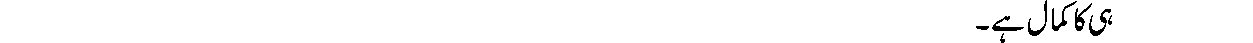

In [ ]:
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]).convert("RGB")
image

In [ ]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

ہی کا کمال ہے


In [ ]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(
    "google/vit-base-patch16-384", "urduhack/roberta-urdu-small"
)
# set decoder config to causal lm
model.config.decoder.is_decoder = True
model.config.decoder.add_cross_attention = True

In [ ]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [ ]:
from datasets import load_metric

cer_metric = load_metric("cer")

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [ ]:
from transformers import default_data_collator
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Using amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1
  Num Epochs = 3
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 3


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=3, training_loss=12.156770706176758, metrics={'train_runtime': 3.3658, 'train_samples_per_second': 0.891, 'train_steps_per_second': 0.891, 'total_flos': 1598481352359936.0, 'train_loss': 12.156770706176758, 'epoch': 3.0})

In [ ]:
model.save_pretrained('./finetune/')

Configuration saved in ./finetune/config.json
Model weights saved in ./finetune/pytorch_model.bin


In [ ]:
import requests 
model = VisionEncoderDecoderModel.from_pretrained("./finetune/")
#processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")

url = "https://fki.tic.heia-fr.ch/static/img/a01-122-02.jpg" 
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
#image = Image.open('/content/6.png').convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values 
generated_ids = model.generate(pixel_values)

generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [ ]:
generated_text

'ak among among among removed removed removed motion motion provides provides provides motion motion motion removed removed Syria Syria Syria removed removed trial trial trial forced forced forcedeteretereter compensation compensation compensation    Republic Republic Republic   compensation compensation college college compensation compensationetereter morning morning morninghalfhalfhalf removed removed Republic Republic motion provides motion'

In [ ]:
from transformers import VisionEncoderDecoderModel
from transformers import DeiTModel, DeiTConfig
from transformers import AutoTokenizer, AutoModelForMaskedLM

# initialize a vit-bert from a pretrained ViT and a pretrained BERT model. Note that the cross-attention layers will be randomly initialized
model = AutoModelForMaskedLM.from_pretrained("urduhack/roberta-urdu-small")
# saving model after fine-tuning
model.save_pretrained("./urduhack-bert")
# load fine-tuned model
model = AutoModelForMaskedLM.from_pretrained("./urduhack-bert")